# Analysis of DNA-MERFISH for CTP11

by Pu Zheng

2022.02.15

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_0\20220215-P_brain_CTP11-1000_CTP12_from0208

This data is DNA of uncleared MERFISH RNA:
    \\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear


In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

37148


# 1. Pre-processing info

In [2]:
fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_0\20220215-P_brain_CTP11-1000_CTP12_from0208',
             'save_folder':r'\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208',
             'experiment_type': 'DNA',
             'num_threads': 25,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':True,
                     'corr_bleed':True,
                     'min_num_seeds':10,
                     'max_num_seeds': 2000,
                     'spot_seeding_th': 1000,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':False
                 }, 
             }

## 1.1 define required floders

In [3]:
save_folder = fov_param['save_folder']

save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")


127 fovs detected
Use segmentation_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation
Use cand_spot_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\CandSpots
Use decoder_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder


In [4]:
pixel_sizes = np.array(fov_param['shared_parameters']['distance_zxy'])
single_im_size = np.array(fov_param['shared_parameters']['single_im_size'])
intensity_th = np.array(fov_param['shared_parameters']['spot_seeding_th'])

In [5]:
save_fov_ids = save_fov_ids[:113]
save_filenames = save_filenames[:113]

# 2. Partiton spots into cells

## 2.1 (For DNA-only) run segmentation

## (For DNA after dense MERFISH)

In [8]:
# MERFISH segmentation
merfish_segmentation_folder = r'I:\MERFISH_Analysis\Cellpose\20220208-P_brain_M1_nonclear\CellPoseSegment\features'
merfish_dapi_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear\Segmentation_Cellpose'
# generate alignment
rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear'
rna_alignment_file = os.path.join(rna_data_folder, 'Alignment', '10x_positions_before.txt')
dna_alignment_file = os.path.join(fov_param['data_folder'], 'Alignment', '10x_positions_after.txt')
print(os.path.exists(rna_alignment_file), os.path.exists(dna_alignment_file))
R, t = ia.correction_tools.alignment.align_manual_points(rna_alignment_file, dna_alignment_file,
                                                         save_folder=save_folder)

True True
- Manually picked points aligned, rotation:
[[ 0.99989048 -0.01479949]
 [ 0.01479949  0.99989048]],
 translation:[   50.27017055 -1393.00834786]
-- rotation matrix saved to file:\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\rotation
-- translation matrix saved to file:\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\translation


In [92]:
reload(ia.correction_tools.alignment)
reload(ia.segmentation_tools.cell)

<module 'ImageAnalysis3.segmentation_tools.cell' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\segmentation_tools\\cell.py'>

In [ ]:
%matplotlib inline
# translate given_id into
from ImageAnalysis3.segmentation_tools.cell import translate_segmentation
from ImageAnalysis3.figure_tools import plot_segmentation
from ImageAnalysis3.segmentation_tools.cell import interploate_z_masks

from scipy.ndimage import grey_dilation

dialation_dimension = 4
overwrite_segmentation = False

_fovcell_2_uid = {}
_fov_2_Zcoords = {}

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    
    # segmentation filename
    segmentation_filename = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.npy') )
    
    if os.path.exists(segmentation_filename) and not overwrite_segmentation:
        print(f"directly load segmentation from file: {segmentation_filename}")
        dna_mask = np.load(segmentation_filename)
    else:
        print(f"translate segmentation of fov-{_fov_id} from MERFISH")
        # Load DAPI
        with h5py.File(_save_filename, "r", libver='latest') as _f:
            _fov_name = _f.attrs['fov_name']
            # load DAPI
            dapi_im = _f.attrs['dapi_im']
        # Load RNA-feature
        _rna_feature_filename = os.path.join(merfish_segmentation_folder, f"feature_data_{_fov_id}.hdf5")
        # get z_coordinates
        _z_coords = np.arange(13) # default
        with h5py.File(_rna_feature_filename, 'r') as _f:
            _label_group = _f['labeldata']
            rna_mask = _label_group['label3D'][:]
            rna_mask = np.flip(rna_mask.transpose((0,2,1)), 2)
            # load feature info
            _feature_group = _f['featuredata']
            for _cell_uid in _feature_group.keys():
                _cell_group = _feature_group[_cell_uid]
                _z_coords = _cell_group['z_coordinates'][:]
                _fovcell_2_uid[(_cell_group.attrs['fov'], _cell_group.attrs['label'])] = _cell_uid

        _fov_2_Zcoords[_fov_id] = _z_coords
        # reconstruct full mask
        rna_full_mask = interploate_z_masks(rna_mask, _fov_2_Zcoords[_fov_id],
                                        np.round(np.arange(0,12.5,0.25),2), )

        rna_dapi_filename = os.path.join(merfish_dapi_folder, 
                                         _fov_name.replace('.dax', '_Dapi.npy'))
        rna_dapi_im = np.load(rna_dapi_filename)

        # Align
        dna_mask, rot_dapi_im = translate_segmentation(rna_dapi_im, dapi_im, R, 
                                                       label_before=rna_full_mask, return_new_dapi=True)
        # Do dialation
        dna_mask = grey_dilation(dna_mask, size=dialation_dimension)
        dna_mask[dna_mask==0] = -1
        # Save
        print(f"Save segmentation to :{segmentation_filename}")
        np.save(segmentation_filename.replace('.npy',''), dna_mask)
        
    # Make plot
    mask_savefig = os.path.join(segmentation_folder, 'Figures', 
                                os.path.basename(_save_filename).replace('.hdf5', '_SegmentationMask.png'))
    if not os.path.exists(os.path.dirname(mask_savefig)):
        os.makedirs(os.path.dirname(mask_savefig))
    ax = plot_segmentation.plot_segmentation(dna_mask, save_filename=mask_savefig)
    
    

<IPython.core.display.Javascript object>


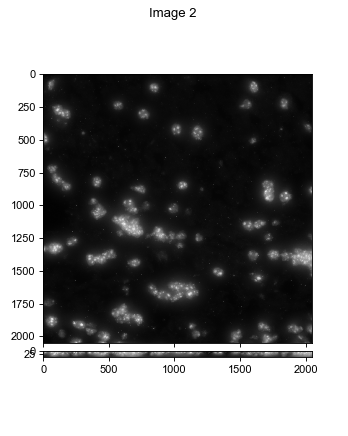

In [84]:
%matplotlib notebook
# visually check
visual_tools.imshow_mark_3d_v2([dna_mask, dapi_im, rot_dapi_im, rna_dapi_im, new_full_mask])

15521

In [96]:
# save
print(len(_fovcell_2_uid))
pickle.dump(_fovcell_2_uid, open(os.path.join(segmentation_folder, f'fovcell_2_uid.pkl'),'wb'))

15521


## 2.2 Partition spots

In [9]:
from ImageAnalysis3.meta_tools.partition_spots import Spots_Partition
reload(ia.meta_tools.partition_spots)
from ImageAnalysis3.classes.preprocess import Spots3D

from ImageAnalysis3.figure_tools import plot_partition

import pandas as pd

In [ ]:
%%time
%matplotlib inline

search_radius = 3
overwrite_cand_spots = False

# create all info
fov_2_spots_df = {}

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation 
    segmentation_filename = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.npy') )
    print(f"Load Segmentation from file: {segmentation_filename}")
    seg_label = np.load(segmentation_filename)
    # savename
    cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.exists(cand_spot_filename) and not overwrite_cand_spots:
        print(f"Directly load cand_spots from file: {cand_spot_filename}")
        fov_2_spots_df[_fov_id] = pd.read_csv(cand_spot_filename)
        
    else:
        print(f"Partition spots for fov-{_fov_id}")

        ## Load spots and their info
        with h5py.File(_save_filename, "r", libver='latest') as _f:
            _grp = _f['combo']
            combo_spots_list = [_spots[_spots[:,0]>0] for _spots in _grp['spots'][:]]
            raw_combo_spots_list = [_spots[_spots[:,0]>0] for _spots in _grp['raw_spots'][:]]
            combo_channels = [_ch.decode() for _ch in _grp['channels'][:]]
            combo_ids = _grp['ids'][:]

        ## partition
        cell_2_spots = {_c:{} for _c in np.arange(1, np.max(seg_label)+1)}
        cell_2_raw_spots = {_c:{} for _c in np.arange(1, np.max(seg_label)+1)}
        label_dict = {}

        for _id, _pts, _raw_pts in zip(combo_ids, combo_spots_list, raw_combo_spots_list):
            # cast spot class
            _spots = Spots3D(_pts, bits=_id, pixel_sizes=pixel_sizes)
            _raw_spots = Spots3D(_pts, bits=_id, pixel_sizes=pixel_sizes)
            # calculate labels
            _labels = Spots_Partition.spots_to_labels(seg_label, _spots, search_radius=search_radius)
            label_dict[_id] = _labels
            # parittion
            for _l in np.unique(_labels):
                if _l > 0:
                    _keep_flags = (_labels==_l)
                    # append
                    cell_2_spots[_l][_id] = _spots[_keep_flags]
                    cell_2_spots[_l][_id].bits = _spots.bits[_keep_flags]
                    cell_2_raw_spots[_l][_id] = _raw_spots[_keep_flags]
                    cell_2_raw_spots[_l][_id].bits = _raw_spots.bits[_keep_flags]
        ## plot stats
        cell_spots_counts = []
        for _cell, _spots_dict in cell_2_spots.items():
            _spots_counts = []
            for _bit in combo_ids:
                if _bit in _spots_dict:
                    _spots_counts.append(len(_spots_dict[_bit]))
                else:
                    _spots_counts.append(0)
            cell_spots_counts.append(np.array(_spots_counts))
        cell_spots_counts = np.array(cell_spots_counts)

        count_savefig = os.path.join(cand_spot_folder, 'Figures', 
                                     os.path.basename(_save_filename).replace('.hdf5', '_SpotCountPerCell.png'))
        if not os.path.exists(os.path.dirname(count_savefig)):
            os.makedirs(os.path.dirname(count_savefig))
        # Plot
        count_ax = plot_partition.plot_cell_spot_counts(cell_spots_counts, save=True, save_filename=count_savefig)

        from ImageAnalysis3.io_tools.spots import FovCell2Spots_2_DataFrame
        # bit_2_channel
        bit_2_channel = {_b:_ch for _b,_ch in zip(combo_ids, combo_channels)}

        spots_df = FovCell2Spots_2_DataFrame(cell_2_spots, _fov_id, bit_2_channel, _fovcell_2_uid,
                                             save_filename=cand_spot_filename)

        # append
        fov_2_spots_df[_fov_id] = spots_df
        

In [11]:
%%time
# decide fovs to merge
merge_fov_ids = save_fov_ids #[1,2,3,4]
merged_spots_df = pd.DataFrame([], columns=fov_2_spots_df[merge_fov_ids[0]].columns)
for _fov_id in merge_fov_ids:
    merged_spots_df = merged_spots_df.append(fov_2_spots_df[merge_fov_ids[_fov_id]], ignore_index=True )

Wall time: 25.1 s


In [12]:
merged_spots_df

fov_id cell_id       height          z           x           y  \
0            0       1  8202.493164   9.285052   89.580498   72.475677   
1            0       1  7974.637695   6.289665   88.340569   75.954262   
2            0       1  6671.041016  13.346459   82.555656   68.370300   
3            0       1  7350.330566   9.333898   74.827011   90.015114   
4            0       1  6740.455078   4.114094   93.616501   68.668106   
...        ...     ...          ...        ...         ...         ...   
8525503     12     149  4495.615234  36.576237  679.684753  846.395813   
8525504     12     149  2549.129150  43.173103  690.910767  835.100464   
8525505     12     149  1726.295288  41.502235  700.842712  859.199463   
8525506     12     149  3139.866455  33.553413  678.705933  851.182800   
8525507     12     149  5652.020996  35.824772  679.475403  846.811096   

           background   sigma_z   sigma_x   sigma_y     sin_t     sin_p  \
0        16403.648438  1.803174  1.799484  1.985787 -1.000000  1.000000   
1        15513.007812  2.412709  3.375523  2.518691  1.000000 -0.315940   
2        15637.180664  1.779254  2.786402  2.485028 -0.916995 -0.645588   
3        15739.626953  2.323035  1.446380  1.417549  0.200427 -0.071362   
4        15617.937500  2.828729  1.947460  1.947912  0.402324 -0.351180   
...               ...       ...       ...       ...       ...       ...   
8525503  16140.738281  2.152524  1.599114  1.421818 -0.125451  0.174423   
8525504  15958.111328  3.201500  3.131536  2.120454 -0.950140  0.718959   
8525505  15811.786133  2.822027  1.439328  1.423826 -0.022774  0.073032   
8525506   5902.191406  1.760420  1.251894  1.489783 -0.135333  0.080883   
8525507   6924.131836  1.809959  1.339211  1.359311 -0.012883  0.126147   

                eps bit channel pixel_z pixel_x pixel_y  
0        951.284668   1     750     250     108     108  
1        633.199219   1     750     250     108     108  
2        514.142944   1     750     250     108     108  
3        431.889069   1     750     250     108     108  
4        487.082428   1     750     250     108     108  
...             ...  ..     ...     ...     ...     ...  
8525503  226.526108  55     750     250     108     108  
8525504  325.430145  55     750     250     108     108  
8525505  182.948700  55     750     250     108     108  
8525506  235.301346  66     647     250     108     108  
8525507  203.588196  82     647     250     108     108  

[8525508 rows x 18 columns]

In [13]:
# Save
merged_spots_filename = os.path.join(cand_spot_folder, 
    f"merged_CandSpots_fov-{min(merge_fov_ids)}-{max(merge_fov_ids)}.csv")
print(merged_spots_filename)
merged_spots_df.to_csv(merged_spots_filename, index=False)

\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\CandSpots\merged_CandSpots_fov-0-12.csv


# 3. Test Decoding

## 3.1 load codebook

In [6]:
import pandas as pd
codebook_filename = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv'
#
codebook_df = pd.read_csv(codebook_filename, header=0)
codebook_df

name    id  NDB_784  NDB_755  NDB_826  NDB_713  NDB_865  \
0        1:3740000-3760000     1        0        0        0        0        0   
1        1:6240000-6260000     2        0        0        0        0        0   
2        1:8740000-8760000     3        0        0        0        0        0   
3      1:11240000-11260000     4        0        0        0        0        0   
4      1:13740000-13760000     5        0        0        0        0        0   
..                     ...   ...      ...      ...      ...      ...      ...   
983  X:161240000-161260000  1057        0        0        1        0        0   
984  X:163740000-163760000  1058        0        0        0        0        0   
985  X:166240000-166260000  1059        0        0        0        0        0   
986  X:168740000-168760000  1060        0        0        0        0        0   
987      Y:1240000-1260000  1062        0        0        0        0        0   

     NDB_725  NDB_817  NDB_710  ...  NDB_824  NDB_712  NDB_818  NDB_940  \
0          0        0        0  ...        0        0        0        0   
1          0        0        0  ...        0        0        0        0   
2          0        0        0  ...        0        0        0        0   
3          0        0        0  ...        0        0        0        1   
4          0        0        0  ...        0        0        1        0   
..       ...      ...      ...  ...      ...      ...      ...      ...   
983        0        0        0  ...        0        0        0        0   
984        0        0        0  ...        0        0        0        0   
985        1        0        0  ...        0        0        0        0   
986        0        0        0  ...        0        0        0        0   
987        0        0        1  ...        0        0        0        0   

     NDB_872  NDB_934  NDB_926  NDB_910  chr  chr_order  
0          0        0        0        0    1          0  
1          0        0        0        0    1          1  
2          0        0        0        0    1          2  
3          0        0        0        0    1          3  
4          0        0        0        0    1          4  
..       ...      ...      ...      ...  ...        ...  
983        0        1        0        0    X         52  
984        1        0        0        0    X         53  
985        0        0        0        0    X         54  
986        0        0        0        0    X         55  
987        0        0        0        0    Y          0  

[988 rows x 103 columns]

## 3.2 load spot files

'\\\\mendel\\Mendel_SSD1\\Pu_Temp\\20220215-P_brain_CTP11-1000_CTP12_from0208\\Conv_zscan_000.hdf5'

In [7]:
with h5py.File(save_filenames[0], "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_channels = [_ch.decode() for _ch in _grp['channels'][:]]
    combo_ids = _grp['ids'][:]
    
bit_2_channel = {_b:_ch for _b,_ch in zip(combo_ids, combo_channels)}

## 3.3 test decode one cell

In [493]:
%%time
from ImageAnalysis3.classes import decode
reload(decode)

overwrite_decoder = False
pair_search_radius = 250

decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"Prepare decoding args for fov: {_fov_id}")
    # load fov_df
    cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f'Fov-{_fov_id}_Cell-{_cell_id}_Decoder.hdf5')
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]

        _args = (_cell_spots_df, codebook_df, _decoder_filename, 
                 False, True, bit_2_channel,
                 pixel_sizes, 2, 0.1, 
                 pair_search_radius, -1, 1, 5, 0, -25, 
                 False, overwrite_decoder, True, False) 
        # append
        decode_args.append(_args)
    
    if _fov_id > 5:
        break
print(len(decode_args))

Prepare decoding args for fov: 0
Prepare decoding args for fov: 1
Prepare decoding args for fov: 2
Prepare decoding args for fov: 3
Prepare decoding args for fov: 4
Prepare decoding args for fov: 5
Prepare decoding args for fov: 6
968
Wall time: 18.4 s


In [494]:
# test run one cell
%matplotlib inline
reload(decode)

_cell_ind = 10
test_args = decode_args[_cell_ind]
#test_args = list(decode_args[_cell_ind])
#test_args[-2] = True
decoder = decode.batch_decode_DNA(*tuple(test_args) )

- 7962 pairs kept given search radius 250 nm.
- search spot_groups given search radius 250 nm, max_usage=1


100%|██████████████████████████████████████████████████████████████████████████| 7962/7962 [00:00<00:00, 107514.40it/s]


- 2106 spot_groups detected
- split found tuples into chromosomes. 
- generate randomized spot pairs 
- generate chr_2_kdtree. 
- Saving decoder into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Fov-0_Cell-11_Decoder.hdf5
[] True


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['uid', 'channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  encoding=encoding,


In [478]:
decoder._save_basic()

- Saving decoder into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Fov-0_Cell-11_Decoder.hdf5
[] True


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['uid', 'channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  encoding=encoding,


In [490]:
decoder.cand_spots.

array([ 1,  1,  1, ..., 99, 99, 99])

In [492]:
decoder.uid

AttributeError: 'DNA_Merfish_Decoder' object has no attribute 'uid'

In [281]:
_savefile = decoder.savefile.replace('.pkl', '.hdf5')

In [296]:
with h5py.File(_savefile, 'r') as _f:
    print(_f.keys())
    print(_f['cand_spots'].keys())
    print(_f['spot_groups'].keys())

<KeysViewHDF5 ['cand_spots', 'codebook', 'spot_groups']>
<KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values', 'block1_items', 'block1_values']>
<KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values', 'block1_items', 'block1_values', 'block2_items', 'block2_values']>


In [290]:
decoder.cand_spots_df.to_hdf(_savefile, 'cand_spots')

reload(ia.io_tools.spots)
from ImageAnalysis3.io_tools.spots import SpotTuple_2_Dict
infoDict_list = [SpotTuple_2_Dict(_g, decoder.fov_id, decoder.cell_id, None, bit_2_channel, codebook_df) for _g in decoder.spot_groups]
decoder_group_df = pd.DataFrame(infoDict_list,)

decoder_group_df.to_hdf(_savefile, 'spot_groups')

decoder.codebook_df.to_hdf(_savefile, 'codebook')

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['uid', 'channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  encoding=encoding,


In [464]:
decoder_group_df.to_hdf(_savefile, 'spot_groups', complevel=1, complib='blosc:zstd')

In [477]:
test_df = pd.read_hdf(decoder.savefile, 'cand_spots')
test_df

fov_id  cell_id        height          z            x            y  \
91406       0       11  11706.566406   8.673130  1413.227783  1593.017334   
91407       0       11  11236.354492  14.309624  1408.671509  1571.637329   
91408       0       11  11328.032227  13.487408  1363.407227  1584.731934   
91409       0       11  11404.791016  10.935159  1387.498047  1583.866333   
91410       0       11  10267.621094  21.157572  1382.337524  1566.720093   
...       ...      ...           ...        ...          ...          ...   
98096       0       11   1516.819092  16.914665  1384.693115  1582.571167   
98097       0       11   1404.052124  10.367239  1394.460693  1576.623047   
98098       0       11   2024.797119  31.296230  1375.263916  1603.325928   
98099       0       11    644.801819  24.888237  1368.832886  1610.157959   
98100       0       11   1861.176880  21.348740  1380.939453  1560.350098   

         background   sigma_z   sigma_x   sigma_y     sin_t     sin_p  \
91406  14970.265625  1.941240  1.408414  1.651786  0.120093 -0.301653   
91407  15002.317383  1.928039  1.851066  1.573997 -1.000000  0.154035   
91408  15355.096680  1.571502  1.524801  1.946795  0.757561 -0.733608   
91409  15657.073242  1.966340  1.528360  1.673405 -0.132010  0.406704   
91410  16211.797852  2.552703  1.487608  1.682874 -0.295027  0.508828   
...             ...       ...       ...       ...       ...       ...   
98096  16235.158203  2.842435  2.790187  2.495333 -1.000000  1.000000   
98097  15504.777344  1.570537  2.112654  1.826791  0.210220 -0.829806   
98098  15680.779297  3.999995  3.801258  3.281803 -1.000000  0.462215   
98099  17162.220703  4.000000  1.380598  4.000000 -1.000000 -1.000000   
98100  13719.958008  3.319833  4.000000  3.376971  1.000000 -1.000000   

              eps  bit  channel  uid  pixel_z  pixel_x  pixel_y  
91406  485.039703    1      750  NaN      250      108      108  
91407  536.816772    1      750  NaN      250      108      108  
91408  655.729370    1      750  NaN      250      108      108  
91409  410.426361    1      750  NaN      250      108      108  
91410  679.728271    1      750  NaN      250      108      108  
...           ...  ...      ...  ...      ...      ...      ...  
98096  245.125519   99      750  NaN      250      108      108  
98097  195.314392   99      750  NaN      250      108      108  
98098  210.294830   99      750  NaN      250      108      108  
98099  274.362061   99      750  NaN      250      108      108  
98100  266.966766   99      750  NaN      250      108      108  

[6695 rows x 19 columns]

In [462]:
test_df = pd.read_hdf(_savefile, 'spot_groups')
test_df

fov_id  cell_id   uid      height_0        z_0          x_0  \
0          0       11  None  14033.312500  25.792822  1392.539307   
1          0       11  None  14644.545898   3.717108  1415.957642   
2          0       11  None  15259.702148   8.471916  1391.091919   
3          0       11  None  14893.258789  10.994237  1398.796143   
4          0       11  None  11675.551758  15.346178  1406.498901   
...      ...      ...   ...           ...        ...          ...   
2101       0       11  None   6510.998535  13.194921  1411.651245   
2102       0       11  None   4054.824707  11.251160  1366.369629   
2103       0       11  None   1263.595459  28.871851  1388.363281   
2104       0       11  None   2381.312256   9.843101  1382.306152   
2105       0       11  None   1391.875488  27.433645  1391.726074   

              y_0  background_0  sigma_z_0  sigma_x_0  ...  channel_2  \
0     1588.719604  17308.458984   2.442491   1.623767  ...        750   
1     1593.176270   7878.192383   1.409765   1.369117  ...        647   
2     1617.118652   9249.614258   1.630328   1.693404  ...        647   
3     1580.548828   7427.979492   1.658423   1.326038  ...        647   
4     1613.028320  16403.740234   2.423249   1.943026  ...        750   
...           ...           ...        ...        ...  ...        ...   
2101  1606.549438  15065.522461   2.453035   3.634053  ...        NaN   
2102  1591.337402   5435.848633   2.895522   2.922741  ...        NaN   
2103  1631.457397  12253.089844   4.000000   1.645417  ...        NaN   
2104  1570.366699  17307.466797   2.554531   2.632966  ...        NaN   
2105  1610.305420   5991.339355   4.000000   2.144201  ...        NaN   

      cand_spot_ind_2  pixel_z  pixel_x  pixel_y region_id      start  \
0              4662.0      250      108      108       844   83740000   
1              2070.0      250      108      108       172   51240000   
2              1371.0      250      108      108       573   28740000   
3              3541.0      250      108      108       591   73740000   
4              3768.0      250      108      108        72  181240000   
...               ...      ...      ...      ...       ...        ...   
2101              NaN      250      108      108         1    3740000   
2102              NaN      250      108      108       788   68740000   
2103              NaN      250      108      108       239   56240000   
2104              NaN      250      108      108         9   23740000   
2105              NaN      250      108      108       420   48740000   

            end  chr  chr_order  
0      83760000   15         31  
1      51260000    3         19  
2      28760000   10         10  
3      73760000   10         28  
4     181260000    1         71  
...         ...  ...        ...  
2101    3760000    1          0  
2102   68760000   14         19  
2103   56260000    4         21  
2104   23760000    1          8  
2105   48760000    7         10  

[2106 rows x 53 columns]

In [311]:
test_df['channel_2'].values

TypeError: '<' not supported between instances of 'float' and 'str'

['fov_id',
 'cell_id',
 'uid',
 'height_0',
 'z_0',
 'x_0',
 'y_0',
 'background_0',
 'sigma_z_0',
 'sigma_x_0',
 'sigma_y_0',
 'sin_t_0',
 'sin_p_0',
 'eps_0',
 'bit_0',
 'channel_0',
 'cand_spot_ind_0',
 'height_1',
 'z_1',
 'x_1',
 'y_1',
 'background_1',
 'sigma_z_1',
 'sigma_x_1',
 'sigma_y_1',
 'sin_t_1',
 'sin_p_1',
 'eps_1',
 'bit_1',
 'channel_1',
 'cand_spot_ind_1',
 'height_2',
 'z_2',
 'x_2',
 'y_2',
 'background_2',
 'sigma_z_2',
 'sigma_x_2',
 'sigma_y_2',
 'sin_t_2',
 'sin_p_2',
 'eps_2',
 'bit_2',
 'channel_2',
 'cand_spot_ind_2',
 'pixel_z',
 'pixel_x',
 'pixel_y',
 'region_id',
 'start',
 'end',
 'chr',
 'chr_order']

In [331]:
import re

In [361]:
re.findall(r'^(.+)_([0-9]+)$', 'region_id')

[]

In [431]:
reload(ia.classes.preprocess)

<module 'ImageAnalysis3.classes.preprocess' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\preprocess.py'>

In [456]:
reload(ia.io_tools.spots)

_test_groups = ia.io_tools.spots.Dataframe_2_SpotGroups(decoder_group_df)

In [459]:
_test_groups[-1].spots, decoder.spot_groups[-1].spots

(Spots3D([[ 1.3918755e+03,  2.7433645e+01,  1.3917261e+03,  1.6103054e+03,
            5.9913394e+03,  4.0000000e+00,  2.1442013e+00,  2.1942782e+00,
            1.9218113e-01,  4.5353225e-01,  1.8062994e+02],
          [ 2.6776565e+03,  2.6527254e+01,  1.3921539e+03,  1.6111814e+03,
            7.8188530e+03,  3.0503576e+00,  2.2323771e+00,  2.3742025e+00,
           -6.7189807e-01,  5.1886439e-01,  2.2320297e+02]], dtype=float32),
 Spots3D([[ 1.39187549e+03,  2.74336452e+01,  1.39172607e+03,
            1.61030542e+03,  5.99133936e+03,  4.00000000e+00,
            2.14420128e+00,  2.19427824e+00,  1.92181125e-01,
            4.53532249e-01,  1.80629944e+02],
          [ 2.67765649e+03,  2.65272541e+01,  1.39215393e+03,
            1.61118140e+03,  7.81885303e+03,  3.05035758e+00,
            2.23237705e+00,  2.37420249e+00, -6.71898067e-01,
            5.18864393e-01,  2.23202972e+02]]))

844

In [366]:
int(re.findall(r'^(.+)_([0-9]+)$', 'cand_spot_ind_2')[0][-1])

2

In [438]:
_grp.chr_order

31

In [375]:
np.isnan(np.array(_grp_row['sin_p_2']))

True

In [371]:
for _ind, _grp_row in decoder_group_df.iterrows():
    print(_ind, _grp_row)
    

0 fov_id                     0
cell_id                   11
uid                     None
height_0             14033.3
z_0                  25.7928
x_0                  1392.54
y_0                  1588.72
background_0         17308.5
sigma_z_0            2.44249
sigma_x_0            1.62377
sigma_y_0            1.63934
sin_t_0            0.0584892
sin_p_0            -0.105636
eps_0                 534.91
bit_0                     43
channel_0                750
cand_spot_ind_0         2928
height_1             14096.5
z_1                  25.7931
x_1                  1392.51
y_1                  1588.84
background_1         9655.23
sigma_z_1            2.16043
sigma_x_1            1.36293
sigma_y_1            1.30729
sin_t_1             0.090948
sin_p_1            -0.198828
eps_1                724.771
bit_1                     60
channel_1                647
cand_spot_ind_1         4082
height_2             9535.68
z_2                  25.8792
x_2                  1392.41
y_2         

Name: 164, dtype: object
165 fov_id                     0
cell_id                   11
uid                     None
height_0             10697.6
z_0                  27.2884
x_0                  1384.45
y_0                  1618.05
background_0         17630.9
sigma_z_0            2.63384
sigma_x_0            1.53776
sigma_y_0            1.82587
sin_t_0            0.0753516
sin_p_0            -0.142665
eps_0                 559.22
bit_0                      3
channel_0                750
cand_spot_ind_0          155
height_1             8644.52
z_1                  27.1628
x_1                  1384.12
y_1                  1617.87
background_1         17083.6
sigma_z_1            2.43588
sigma_x_1            1.53815
sigma_y_1            1.68673
sin_t_1               0.1107
sin_p_1            -0.190075
eps_1                435.132
bit_1                     23
channel_1                750
cand_spot_ind_1         1601
height_2             6639.23
z_2                  26.2674
x_2           

Name: 323, dtype: object
324 fov_id                     0
cell_id                   11
uid                     None
height_0             13261.9
z_0                  11.7309
x_0                     1379
y_0                  1585.62
background_0         17578.3
sigma_z_0            1.59384
sigma_x_0            1.71947
sigma_y_0            1.58665
sin_t_0                    1
sin_p_0                   -1
eps_0                499.662
bit_0                     37
channel_0                750
cand_spot_ind_0         2510
height_1             13646.5
z_1                  11.6293
x_1                  1380.01
y_1                  1585.48
background_1         9669.99
sigma_z_1            1.95041
sigma_x_1            1.77515
sigma_y_1            1.40306
sin_t_1                   -1
sin_p_1            -0.337563
eps_1                865.496
bit_1                     38
channel_1                647
cand_spot_ind_1         2584
height_2             7405.45
z_2                  11.8607
x_2           

Name: 468, dtype: object
469 fov_id                     0
cell_id                   11
uid                     None
height_0             4718.25
z_0                  27.9172
x_0                  1345.69
y_0                  1584.69
background_0         15546.4
sigma_z_0            2.41943
sigma_x_0            1.61148
sigma_y_0            1.53193
sin_t_0            -0.145101
sin_p_0             0.176846
eps_0                251.767
bit_0                      3
channel_0                750
cand_spot_ind_0          182
height_1             4350.42
z_1                  27.7762
x_1                  1345.54
y_1                  1585.31
background_1         6567.09
sigma_z_1             2.3304
sigma_x_1            1.37774
sigma_y_1            1.50884
sin_t_1           -0.0282596
sin_p_1            -0.112776
eps_1                349.536
bit_1                     24
channel_1                647
cand_spot_ind_1         1703
height_2             2063.53
z_2                  28.1857
x_2           

621 fov_id                     0
cell_id                   11
uid                     None
height_0             7409.15
z_0                  24.0797
x_0                  1361.08
y_0                  1588.51
background_0         8629.34
sigma_z_0            2.18888
sigma_x_0            1.38707
sigma_y_0            1.50477
sin_t_0            -0.233296
sin_p_0            -0.187551
eps_0                311.275
bit_0                     74
channel_0                647
cand_spot_ind_0         5010
height_1             8253.18
z_1                  23.5215
x_1                  1361.16
y_1                  1588.32
background_1         8480.87
sigma_z_1            2.15068
sigma_x_1            1.57946
sigma_y_1             1.7165
sin_t_1            -0.264223
sin_p_1             0.083323
eps_1                457.481
bit_1                     92
channel_1                647
cand_spot_ind_1         6183
height_2             9983.07
z_2                  24.5685
x_2                  1360.27
y_2       

Name: 766, dtype: object
767 fov_id                     0
cell_id                   11
uid                     None
height_0             10786.6
z_0                  15.6589
x_0                   1372.8
y_0                  1591.33
background_0         8290.27
sigma_z_0            2.00995
sigma_x_0            1.41041
sigma_y_0            1.46259
sin_t_0            0.0111531
sin_p_0            0.0920081
eps_0                508.621
bit_0                     42
channel_0                647
cand_spot_ind_0         2856
height_1             11158.1
z_1                  15.1086
x_1                  1373.44
y_1                  1590.56
background_1         9356.88
sigma_z_1            1.61916
sigma_x_1             3.0422
sigma_y_1            2.11614
sin_t_1            -0.749545
sin_p_1            -0.559727
eps_1                 984.54
bit_1                     50
channel_1                647
cand_spot_ind_1         3400
height_2             5544.24
z_2                  16.0614
x_2           

Name: 915, dtype: object
916 fov_id                    0
cell_id                  11
uid                    None
height_0            2597.87
z_0                 17.7535
x_0                  1362.5
y_0                 1567.59
background_0        4176.46
sigma_z_0           2.59103
sigma_x_0           2.47515
sigma_y_0           1.30636
sin_t_0            0.977617
sin_p_0           -0.622872
eps_0                266.66
bit_0                    66
channel_0               647
cand_spot_ind_0        4494
height_1            2047.25
z_1                 17.3714
x_1                 1362.34
y_1                 1567.92
background_1        15795.5
sigma_z_1           1.67985
sigma_x_1           1.70423
sigma_y_1           1.68982
sin_t_1                   1
sin_p_1                   1
eps_1               217.819
bit_1                    73
channel_1               750
cand_spot_ind_1        4983
height_2            2075.39
z_2                 17.2607
x_2                 1362.21
y_2                

Name: 1062, dtype: object
1063 fov_id                       0
cell_id                     11
uid                       None
height_0               1904.23
z_0                     30.447
x_0                     1370.8
y_0                    1604.04
background_0           14446.6
sigma_z_0              2.51491
sigma_x_0              2.18158
sigma_y_0              2.87266
sin_t_0           -0.000388682
sin_p_0                     -1
eps_0                  252.961
bit_0                       65
channel_0                  750
cand_spot_ind_0           4446
height_1               1904.53
z_1                     29.654
x_1                    1370.62
y_1                    1605.11
background_1           6096.02
sigma_z_1                    4
sigma_x_1              2.02993
sigma_y_1              1.81304
sin_t_1              -0.846606
sin_p_1              -0.611103
eps_1                  288.069
bit_1                       66
channel_1                  647
cand_spot_ind_1           4514
height_2

Name: 1205, dtype: object
1206 fov_id                     0
cell_id                   11
uid                     None
height_0             12425.7
z_0                  22.0313
x_0                  1395.52
y_0                  1601.39
background_0         10008.2
sigma_z_0            1.39735
sigma_x_0            1.63065
sigma_y_0             2.2111
sin_t_0            -0.398023
sin_p_0            -0.516389
eps_0                992.254
bit_0                      2
channel_0                647
cand_spot_ind_0           76
height_1             10350.6
z_1                  21.8401
x_1                  1395.18
y_1                  1602.48
background_1         9715.63
sigma_z_1            2.38892
sigma_x_1            1.73783
sigma_y_1            1.76968
sin_t_1            0.0263081
sin_p_1            -0.197321
eps_1                632.698
bit_1                     24
channel_1                647
cand_spot_ind_1         1669
height_2                 NaN
z_2                      NaN
x_2         

Name: 1349, dtype: object
1350 fov_id                     0
cell_id                   11
uid                     None
height_0               10051
z_0                   22.239
x_0                  1399.55
y_0                  1602.54
background_0         8660.81
sigma_z_0            1.85621
sigma_x_0            1.68459
sigma_y_0            2.13939
sin_t_0           -0.0728874
sin_p_0                   -1
eps_0                660.688
bit_0                     52
channel_0                647
cand_spot_ind_0         3554
height_1             3897.67
z_1                  22.5835
x_1                  1399.19
y_1                  1602.29
background_1         15937.7
sigma_z_1            2.67921
sigma_x_1            2.05909
sigma_y_1            2.86143
sin_t_1             -0.22749
sin_p_1                    1
eps_1                372.651
bit_1                     75
channel_1                750
cand_spot_ind_1         5081
height_2                 NaN
z_2                      NaN
x_2         

Name: 1490, dtype: object
1491 fov_id                     0
cell_id                   11
uid                     None
height_0             2576.32
z_0                  18.5757
x_0                  1396.36
y_0                  1564.59
background_0         5636.25
sigma_z_0             2.4862
sigma_x_0             2.0352
sigma_y_0            1.88705
sin_t_0            -0.376841
sin_p_0            -0.286564
eps_0                 285.79
bit_0                     30
channel_0                647
cand_spot_ind_0         2113
height_1             2454.43
z_1                  18.9941
x_1                  1395.93
y_1                  1564.84
background_1         6855.78
sigma_z_1             3.9894
sigma_x_1            2.24138
sigma_y_1            2.26681
sin_t_1            -0.371485
sin_p_1            0.0520645
eps_1                 267.86
bit_1                     60
channel_1                647
cand_spot_ind_1         4123
height_2                 NaN
z_2                      NaN
x_2         

Name: 1642, dtype: object
1643 fov_id                     0
cell_id                   11
uid                     None
height_0              2120.7
z_0                  23.4931
x_0                  1370.51
y_0                  1619.64
background_0         14217.1
sigma_z_0                  4
sigma_x_0                  4
sigma_y_0            3.42101
sin_t_0                    1
sin_p_0            -0.431714
eps_0                253.231
bit_0                     87
channel_0                750
cand_spot_ind_0         5892
height_1             2399.44
z_1                  23.1626
x_1                  1370.06
y_1                  1620.55
background_1         15341.1
sigma_z_1            2.92368
sigma_x_1             2.2301
sigma_y_1            2.78435
sin_t_1             0.207631
sin_p_1                   -1
eps_1                265.533
bit_1                     95
channel_1                750
cand_spot_ind_1         6405
height_2                 NaN
z_2                      NaN
x_2         

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [106]:
sc,dc = 0,0
for _ig, _group in enumerate(decoder.spot_groups):
    #print(_ig, _group.bits)
    if combo_channels[_group.bits[0]-1] == combo_channels[_group.bits[1]-1]:
        sc += 1
    else:
        dc += 1
print(sc,dc)

1185 904


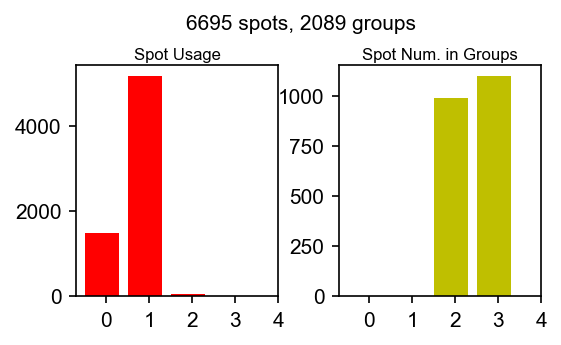

In [107]:
from ImageAnalysis3.figure_tools import plot_decode
reload(figure_tools.plot_decode)
plot_decode.plot_spot_stats(decoder.spot_groups, decoder.spot_usage,
                            show_image=False)

## visualize decoded spots

In [108]:
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")

decode_figure_folder = os.path.join(decoder_folder, 'Figures')
if not os.path.exists(decode_figure_folder):
    os.makedirs(decode_figure_folder)
    print(f"Creating decode_figure_folder: {decode_figure_folder}")
else:
    print(f"Use decode_figure_folder: {decode_figure_folder}")

Use decoder_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder
Creating decode_figure_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Figures


In [502]:
%matplotlib notebook

def rotate(angle):
     ax.view_init(azim=angle)
        
from matplotlib import animation

from matplotlib.cm import Reds, Blues, Spectral
fig = plt.figure(dpi=100)
ax = fig.add_subplot(projection='3d')

_zxys_list = decoder.chr_2_zxys_list['2']

for _ichr, _zxys in enumerate(_zxys_list):
    
    ax.scatter(_zxys[:,1], _zxys[:,2], _zxys[:,0],
               #cmap=Spectral, 
               color=Spectral(_ichr/(len(_zxys_list)+1)),
               #c=homolog_labels,
               alpha=0.7,
               s=3)

    ax.plot(_zxys[:,1], _zxys[:,2], _zxys[:,0], linewidth=0.5,
            alpha=0.7,
            color = Spectral( _ichr/(len(_zxys_list)+1) ) )
    
fig.show()

<IPython.core.display.Javascript object>

AttributeError: 'NoneType' object has no attribute 'chr_2_zxys_list'

## 3.4 process all

In [22]:
reload(decode)

<module 'ImageAnalysis3.classes.decode' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\decode.py'>

In [23]:
%%time
# old version
import multiprocessing as mp

print(len(decode_args))
with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(decode.batch_decode_DNA, decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

5905
Wall time: 43.7 s


# 5. Summarize decoder

This step will detect all decoder files so it will merge fovs

In [24]:
#decoder_folder = os.path.join(save_folder, 'Decoder')
decoder_filenames = [os.path.join(decoder_folder, _fl) for _fl in os.listdir(decoder_folder) 
                     if '_Decoder.pkl' in _fl]
print(decoder_folder, len(decoder_filenames))

\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder 8869


In [25]:
%%time
import multiprocessing as mp
load_args = [(_fl, 'chr_2_zxys_list') for _fl in decoder_filenames]
print(len(load_args))
with mp.Pool(44) as load_pool:
    all_chr_2_zxys_list = load_pool.starmap(decode.batch_load_attr, 
                                            load_args, chunksize=1)
    load_pool.close()
    load_pool.join()
    load_pool.terminate()

# summarize
decode_filenames = [_fl for _fl,_item in zip(decoder_filenames, all_chr_2_zxys_list) if _item is not None]
all_chr_2_zxys_list = [_item for _item in all_chr_2_zxys_list if _item is not None]
print(len(all_chr_2_zxys_list))

8869
8869
Wall time: 11min 17s


In [26]:
%%time
import multiprocessing as mp
summary_args = [(_item, codebook_df) for _item in all_chr_2_zxys_list ]

print(len(summary_args))

with mp.Pool(44) as summary_pool: 
    all_zxys_list = summary_pool.starmap(decode.DNA_Merfish_Decoder.summarize_zxys_by_regions, 
                                         summary_args, chunksize=1)
    summary_pool.close()
    summary_pool.join()
    summary_pool.terminate()

8869
Wall time: 14min 15s


<IPython.core.display.Javascript object>


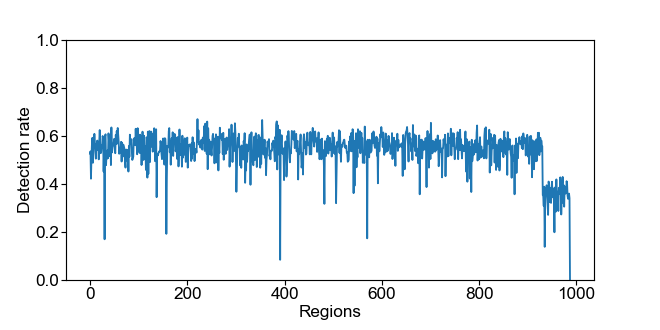

\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Figures_final\loss_rates.png


In [177]:
all_zxys = np.concatenate(all_zxys_list)
loss_rates = np.mean(np.isnan(all_zxys).any(2), axis=0)

fig, ax = plt.subplots(figsize=(4,2),dpi=150)
_l = ax.plot(1-loss_rates, linewidth=0.8)
ax.set_ylim([0,1])
ax.set_xlabel('Regions', labelpad=1, fontsize=7.5)
ax.set_ylabel('Detection rate', labelpad=1, fontsize=7.5)

# border
[i[1].set_linewidth(0.5) for i in ax.spines.items()]
# ticks
ax.tick_params('both', labelsize=7.5, 
               width=0.5, length=2,
               pad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1,)
if save_figure:
    loss_rate_fig_fl = os.path.join(figure_folder, 'loss_rates.png')
    print(loss_rate_fig_fl)
    fig.savefig(loss_rate_fig_fl, transparent=True)
fig.show()

In [30]:
%%time
from scipy.spatial.distance import cdist,pdist,squareform
from tqdm import tqdm

all_zxys = np.concatenate(all_zxys_list)
#all_zxys = np.array(decode_save_dict['zxys'])

all_distmaps = [squareform(pdist(_zxys)).astype(np.float32) for _zxys in tqdm(all_zxys)]

from ImageAnalysis3.classes import postanalysis
median_distmap = postanalysis.parallel_reduce_matrix(all_distmaps, function='nanmedian', axis=0,
                                                     num_threads=44)

100%|████████████████████████████████████████████████████████████████████████████| 17738/17738 [07:26<00:00, 39.75it/s]


Wall time: 17min 15s


In [38]:
%%time
all_contactmaps = np.array(all_distmaps) <= 0.5

contactmap = postanalysis.parallel_reduce_matrix(all_contactmaps, function='nanmean', axis=0,
                                                     num_threads=44)


Wall time: 3min 36s


In [31]:
save_figure = True
#figure_folder = os.path.join(save_folder, 'Figures_final')
figure_folder = os.path.join(decoder_folder, 'Figures_final')
if not os.path.exists(figure_folder):
    print(f"Create figure_folder: {figure_folder}")
    os.makedirs(figure_folder)
else:
    print(f"Use figure_folder: {figure_folder}")

Create figure_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Figures_final


In [32]:
_ordered_chr_names = []
for _chr_name, _chr_reg_id in zip(codebook_df['chr'], codebook_df['chr_order']):
    if _chr_name not in _ordered_chr_names:
        _ordered_chr_names.append(_chr_name)
chr_2_indices = {_chr:np.array(codebook_df.loc[codebook_df['chr']==_chr].index)
                for _chr in np.unique(codebook_df['chr'].values)}

_labels_edges = np.array([0] + [np.max(chr_2_indices[_chr]) for _chr in _ordered_chr_names])

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  


<IPython.core.display.Javascript object>


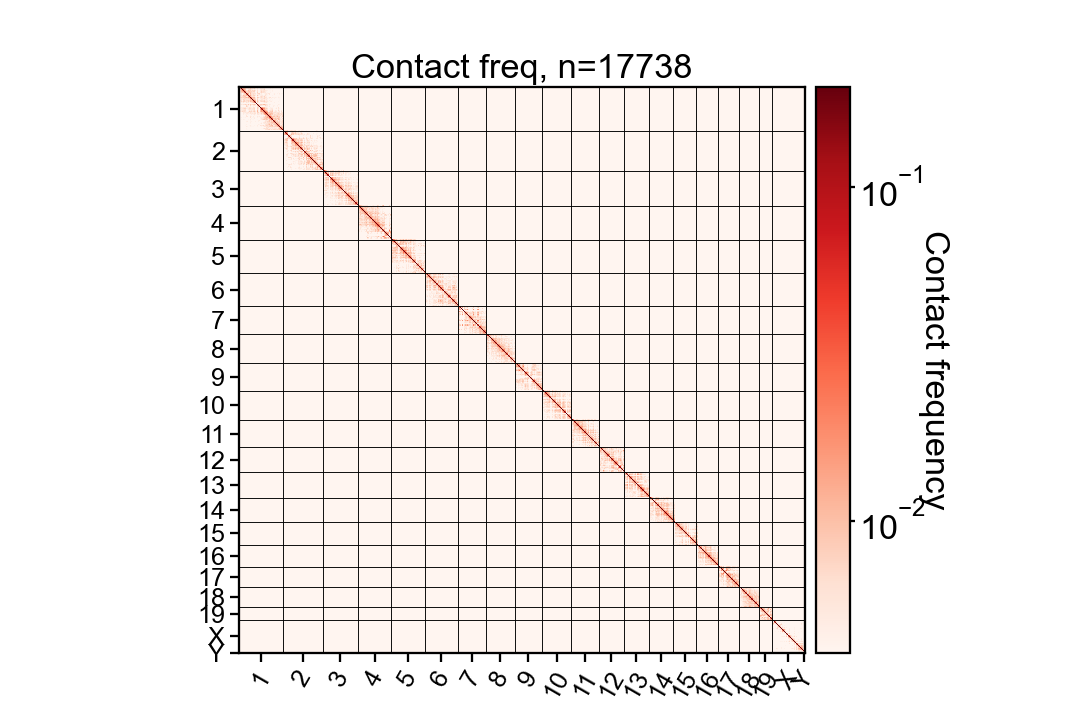

E:\Users\puzheng\Documents\ImageAnalysis3\figure_tools\distmap.py:39: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  vmin=min(color_limits), vmax=max(color_limits), **imshow_kwargs)


In [39]:
from matplotlib.colors import LogNorm
from matplotlib import cm

contact_limits = [0.004, 0.2]
contact_norm = LogNorm(vmin=np.min(contact_limits), 
                       vmax=np.max(contact_limits))
contact_cmap = cm.get_cmap('Reds')
contact_cmap.set_bad(color=[0.,0.,0.,1])

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(
    contactmap, 
    cmap=contact_cmap,
    color_limits=contact_limits,
    color_norm=contact_norm,
    colorbar_labels='Contact frequency',
    ax=ax,
)

ax.set_title(f'Contact freq, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_contact_map.png'), transparent=True)
fig.show()


<IPython.core.display.Javascript object>


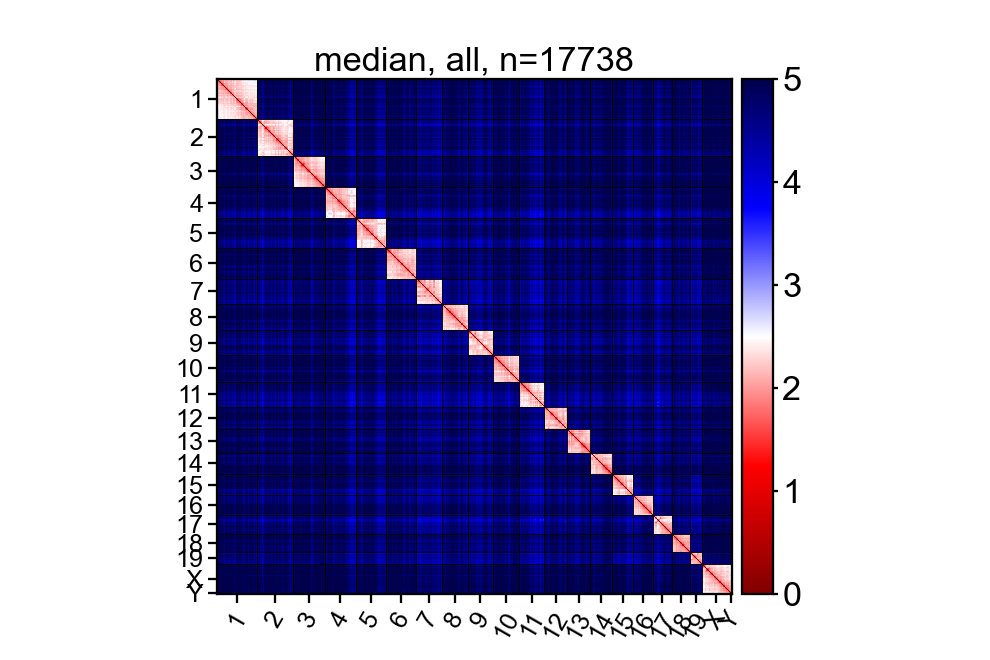

In [500]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(median_distmap, color_limits=[0.,5],
                                          ax=ax,
                                          )
ax.set_title(f'median, all, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_median_distmap.png'), transparent=True)
fig.show()

In [62]:
_total_seg_save_file = os.path.join(segmentation_folder, 'Tests', 'full_segmentation.hdf5')

fovcell_2_uid = {}
with h5py.File(_total_seg_save_file, 'r') as _f:
    for _fov_id in _f.keys():
        _fov_group = _f[_fov_id]
        _uid_group = _fov_group['cell_2_uid']
        for _cell_id in _uid_group.keys():
            fovcell_2_uid[(_fov_id, _cell_id)] = _uid_group[_cell_id][:][0].decode()
print(len(fovcell_2_uid))

18058


In [71]:
import re
_uids = [fovcell_2_uid[re.findall(r'.+Fov-([0-9]+)_Cell-([0-9]+)_Decoder.pkl' , _fl)[0]] for _fl in decoder_filenames]
len(_uids)

8869

In [72]:
print(save_folder)

\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208


8869.0

In [76]:
import scanpy as sc

# load cell type info
merfish_cluster_file = r'\\mendel\Mendel_SSD1\Pu_Temp\20220208MO4_nonclear\filtered_cluster_data_labeled.h5ad'

merfish_df = sc.read_h5ad(merfish_cluster_file)

In [94]:
merfish_df.obs

fov       volume     center_x  \
Unnamed: 0                                                               
103641256736078854362335905444101517866    0   456.326380 -2442.703996   
103997814873698514415264233834720967331    0  1832.677868 -2450.857997   
106718484757835434472919423959947061388    0   264.613134 -2464.735997   
117957268588464775413817122040683059072    0   441.589382 -2401.609995   
119307487964071089478526027943891961677    0  1273.977721 -2473.537997   
...                                      ...          ...          ...   
93204673511625412823579055804861268037   162   160.019008  5460.276199   
95741273838896175969059283691213347291   162   541.104535  5492.946200   
95891862418591609038671701055114620893   162   283.191437  5514.384200   
96656407512209176434513938811993122388   162  1114.627411  5383.866197   
99712434278427654271271822834177214643   162   392.752561  5359.512196   

                                            center_y        min_x  \
Unnamed: 0                                                          
103641256736078854362335905444101517866  1094.180027 -2447.790797   
103997814873698514415264233834720967331  1137.218028 -2459.238797   
106718484757835434472919423959947061388  1132.304028 -2467.662797   
117957268588464775413817122040683059072  1098.230027 -2405.238795   
119307487964071089478526027943891961677  1008.158025 -2480.622797   
...                                              ...          ...   
93204673511625412823579055804861268037   -984.919949  5456.377399   
95741273838896175969059283691213347291  -1001.227950  5484.565400   
95891862418591609038671701055114620893   -985.189949  5509.945400   
96656407512209176434513938811993122388   -863.041946  5377.753397   
99712434278427654271271822834177214643   -924.763948  5355.613396   

                                               max_x        min_y  \
Unnamed: 0                                                          
103641256736078854362335905444101517866 -2437.617196  1089.201227   
103997814873698514415264233834720967331 -2442.477196  1124.733228   
106718484757835434472919423959947061388 -2461.809197  1126.677228   
117957268588464775413817122040683059072 -2397.981195  1091.469227   
119307487964071089478526027943891961677 -2466.453197  1000.533225   
...                                              ...          ...   
93204673511625412823579055804861268037   5464.174999  -988.710749   
95741273838896175969059283691213347291   5501.327000 -1007.718750   
95891862418591609038671701055114620893   5518.823000  -989.034749   
96656407512209176434513938811993122388   5389.978997  -870.558746   
99712434278427654271271822834177214643   5363.410996  -929.202748   

                                               max_y  n_genes_by_counts  \
Unnamed: 0                                                                
103641256736078854362335905444101517866  1099.158827                 15   
103997814873698514415264233834720967331  1149.702829                 32   
106718484757835434472919423959947061388  1137.930828                 17   
117957268588464775413817122040683059072  1104.990828                 15   
119307487964071089478526027943891961677  1015.782825                 33   
...                                              ...                ...   
93204673511625412823579055804861268037   -981.129149                  7   
95741273838896175969059283691213347291   -994.737150                 26   
95891862418591609038671701055114620893   -981.345149                 13   
96656407512209176434513938811993122388   -855.525146                 52   
99712434278427654271271822834177214643   -920.325148                 32   

                                         total_counts leiden leiden_cluster  \
Unnamed: 0                                                                    
103641256736078854362335905444101517866          23.0      8              7   
103997814873698514415264233834720967331         114.0     15         

In [99]:
_class_labels = []
for _uid in _uids:
    _class = merfish_df.obs.loc[merfish_df.obs.index==_uid,'subclass_manual_label'].values
    if len(_class) == 0:
        _class_labels.append('None')
    else:
        _class_labels.append(_class[0])

In [102]:
_classes, _class_counts = np.unique(_class_labels, return_counts=True)

In [109]:
%%time
class_2_distmaps = {}
for _cls in _classes:
    if _cls == 'None' or _cls == 'Other':
        continue
    # get cell_inds
    _cell_inds = np.where(np.array(_class_labels)==_cls)[0]
    _distmap_inds = np.concatenate([[2*_i,2*_i+1] for _i in _cell_inds])
    print(_cls, len(_distmap_inds))
    class_2_distmaps[_cls] = np.array([all_distmaps[_j] for _j in _distmap_inds])

Astro 1012
Endo 508
L2/3 IT 1296
L4/5 IT 990
L5 ET 534
L5 IT 992
L5/6 NP 330
L6 CT 1378
L6 IT 594
L6b 160
Lamp5 86
Micro 196
OPC 438
Oligo 1106
Other 106
Peri 256
Pvalb 418
Sncg 130
Sst 256
VLMC-SMC 210
Vip 160
Wall time: 49.7 s


In [130]:
%%time
class_names = [_cls for _cls, _distmaps in class_2_distmaps.items()]
class_median_dismaps = [postanalysis.parallel_reduce_matrix(_distmaps, function='nanmedian', axis=0, num_threads=44, verbose=True)
                        for _cls, _distmaps in class_2_distmaps.items()]

1012 processed in 17.799s. 
508 processed in 11.871s. 
1296 processed in 23.388s. 
990 processed in 19.498s. 
534 processed in 11.891s. 
992 processed in 18.400s. 
330 processed in 8.457s. 
1378 processed in 24.636s. 
594 processed in 16.192s. 
160 processed in 2.834s. 
86 processed in 1.723s. 
196 processed in 2.804s. 
438 processed in 9.752s. 
1106 processed in 20.297s. 
106 processed in 1.806s. 
256 processed in 4.700s. 
418 processed in 8.926s. 
130 processed in 1.973s. 
256 processed in 4.200s. 
210 processed in 4.098s. 
160 processed in 1.945s. 
Wall time: 3min 42s


## Plot median distmap by cell class

<IPython.core.display.Javascript object>


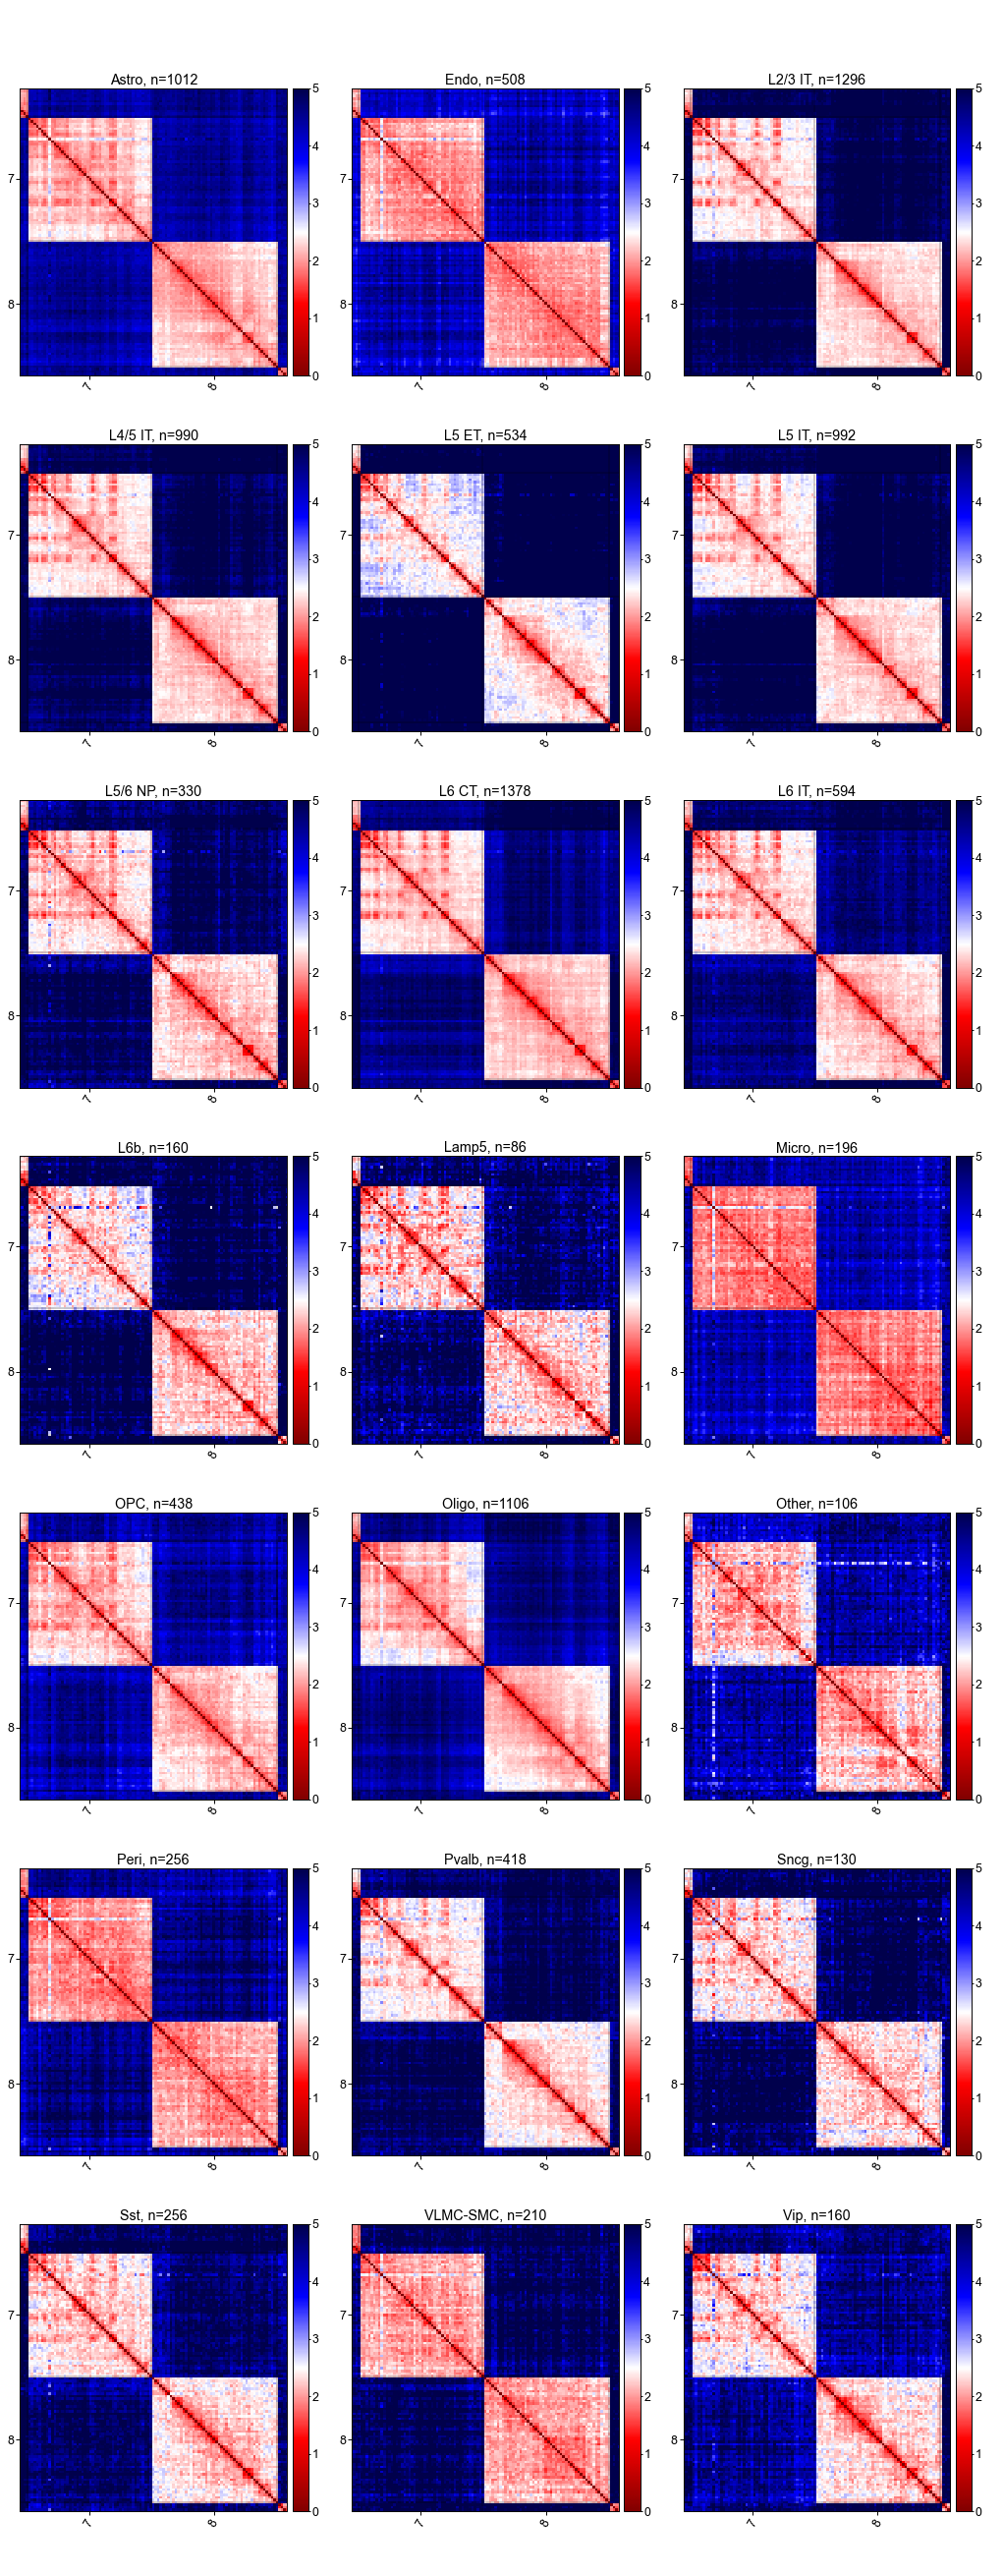

In [501]:
%matplotlib notebook
_single_im_size=2.25
_num_cols = 3
_num_rows =  int(np.ceil(len(class_2_distmaps)/_num_cols))
fig, axes_list = plt.subplots(_num_rows, _num_cols, 
                              figsize=(_single_im_size*_num_cols, _single_im_size*_num_rows*1.1), 
                              dpi=125,
                              sharex=True, sharey=True)
_plot_id = 0
for _row_axes in axes_list:
    for _ax in _row_axes:
        if _plot_id >= len(class_median_dismaps):
            continue
        _ax = ia.figure_tools.distmap.plot_distance_map(
            class_median_dismaps[_plot_id], color_limits=[0,5],
            ticks=(_labels_edges[1:] + _labels_edges[:-1])/2,
            tick_labels=_ordered_chr_names,
            font_size=6.5,
            ax=_ax,)
        _ax.set_title(f'{class_names[_plot_id]}, n={len(class_2_distmaps[class_names[_plot_id]])}', fontsize=7.5, pad=2)
        _ax.hlines(_labels_edges, 0, len(class_median_dismaps[_plot_id]), color='black', linewidth=0.2)
        _ax.vlines(_labels_edges, 0, len(class_median_dismaps[_plot_id]), color='black', linewidth=0.2)
        _ax.xaxis.set_tick_params(which='both', labelbottom=True)
        _ax.yaxis.set_tick_params(which='both', labelleft=True)
        # next plot
        _plot_id += 1

fig.subplots_adjust(wspace=0.15, hspace=0.15, left=0.02, right=0.97, top=0.97, bottom=0.02)
fig.show()
        